## 1. Visualize and Generate Data

[21:58:33] INFO     rollout took 0.32 seconds to execute                                               ]8;id=710064;file:///home/kyle/repos/latent_loco/utils.py\utils.py]8;;\:]8;id=453241;file:///home/kyle/repos/latent_loco/utils.py#132\132]8;;\

(50000, 11, 2) (50000, 10, 1)


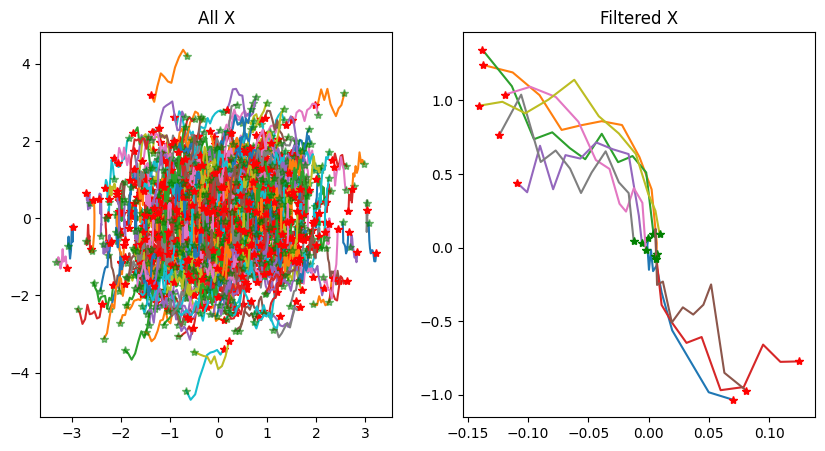

In [2]:
%load_ext autoreload
%autoreload 2
import os, sys, os.path as osp
sys.path.append(osp.dirname(osp.abspath("")))

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from data_gen import *


cfg_datagen = CfgDataGen(ntraj=int(5e4))
rng = jax.random.PRNGKey(1234)
di = DoubleIntegrator(cfg_datagen, rng)
x0s = jax.random.normal(rng, (cfg_datagen.ntraj, 2))

inte_out = di.rollout(x0s, cfg_datagen.dt)
print(inte_out.xs.shape, inte_out.us.shape)

X = inte_out.xs
U = inte_out.us
filtered_inds = ((jnp.abs(X[:,-1,0]) < 0.1*jnp.abs(X[:,0,0])) &
                 (jnp.abs(X[:,-1,1]) < 0.1*jnp.abs(X[:,0,1])))
X_filtered = X[filtered_inds]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_title("All X")
ax2.set_title("Filtered X")

for i in range(1000):
    ax1.plot(X[i,:,0], X[i,:,1])
    ax1.plot(X[i,0,0], X[i,0,1], 'r*')
    ax1.plot(X[i,-1,0], X[i,-1,1], 'g*', alpha=0.5)
for i in range(X_filtered.shape[0]):
    ax2.plot(X_filtered[i,:,0], X_filtered[i,:,1])
    ax2.plot(X_filtered[i,0,0], X_filtered[i,0,1], 'r*')
    ax2.plot(X_filtered[i,-1,0], X_filtered[i,-1,1], 'g*')
plt.show()

In [1]:

%load_ext autoreload
%autoreload 2
import os, sys, os.path as osp
sys.path.append(osp.dirname(osp.abspath("")))

import jax, jax.numpy as jnp, numpy as np
import matplotlib.pyplot as plt

from utils import get_repo_root
from data_gen import *


''' Now actually generate data'''

for ntraj in ["5e4", "5e7"]:
    
    out_file_dir = osp.join(get_repo_root(), "data")
    out_file_path = osp.join(out_file_dir, f"doubinte_data_{ntraj}.npz")
    if not osp.exists(out_file_dir):
        os.makedirs(out_file_dir)


    cfg_datagen = CfgDataGen(ntraj=int(float(ntraj)))
    rng = jax.random.PRNGKey(1234)
    di = DoubleIntegrator(cfg_datagen, rng)
    x0s = jax.random.normal(rng, (cfg_datagen.ntraj, 2))

    inte_out = di.rollout(x0s, cfg_datagen.dt)

    save_rollout(out_file_path, inte_out)

[16:49:40] INFO     rollout took 0.32 seconds to execute                                               ]8;id=445913;file:///home/kyle/repos/latent_loco/utils.py\utils.py]8;;\:]8;id=817096;file:///home/kyle/repos/latent_loco/utils.py#126\126]8;;\

           INFO     Rollout saved to /home/kyle/repos/latent_loco/data/doubinte_data_5e4.npz |      ]8;id=799793;file:///home/kyle/repos/latent_loco/data_gen.py\data_gen.py]8;;\:]8;id=56505;file:///home/kyle/repos/latent_loco/data_gen.py#109\109]8;;\
                    Size: 0.01 GB                                                                                  

[16:49:41] INFO     rollout took 0.35 seconds to execute                                               ]8;id=680406;file:///home/kyle/repos/latent_loco/utils.py\utils.py]8;;\:]8;id=326101;file:///home/kyle/repos/latent_loco/utils.py#126\126]8;;\

[16:49:46] INFO     Rollout saved to /home/kyle/repos/latent_loco/data/doubinte_data_5e7.npz |      ]8;id=769182;file:///home/kyle/repos/latent_loco/data_gen.py\data_gen.py]8;;\:]8;id=469707;file:///home/kyle/repos/latent_loco/data_gen.py#109\109]8;;\
                    Size: 5.96 GB                                                                                  

## 2. Load Data 

In [ ]:

%load_ext autoreload
%autoreload 2
import sys, os.path as osp
sys.path.append(osp.dirname(osp.abspath("")))

import jax, jax.numpy as jnp, numpy as np
import matplotlib.pyplot as plt

from utils import get_repo_root
from data_gen import *
from rom import *


dataset = DoubinteDataset(cfg=CfgDataLoad(), 
                          data_path=osp.join(get_repo_root(), "data/doubinte_data_5e4.npz"))
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, collate_fn=DoubinteDataset.collate_fn)


rom = NNDoubinteROM(CfgNNDoubinteROM())

batch = next(iter(dataloader))
x, xs_next, us= batch['from'], batch['to'], batch['ctrl']
print(x.shape, xs_next.shape, us.shape)

loss_recon = rom.loss_recon(batch)
loss_reproj = rom.loss_reproj(batch)
loss_fwd = rom.loss_fwd(batch)
loss_bwd = rom.loss_bwd(batch)
loss_recon, loss_reproj, loss_fwd, loss_bwd


[22:04:57] INFO     Rollout loaded from /home/kyle/repos/latent_loco/data/doubinte_data_5e4.npz |   ]8;id=639507;file:///home/kyle/repos/latent_loco/data_gen.py\data_gen.py]8;;\:]8;id=421197;file:///home/kyle/repos/latent_loco/data_gen.py#115\115]8;;\
                    Size: 0.01 GB                                                                                  

2 1 3
(128, 2) (128, 4, 2) (128, 4, 1)


[22:04:58] INFO     NNX module saved to /home/kyle/repos/latent_loco/logs/rom_5e4                      ]8;id=722804;file:///home/kyle/repos/latent_loco/utils.py\utils.py]8;;\:]8;id=569918;file:///home/kyle/repos/latent_loco/utils.py#209\209]8;;\

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[00:07:32] INFO     Rollout loaded from /home/kyle/repos/latent_loco/data/doubinte_data_5e4.npz |   ]8;id=11822;file:///home/kyle/repos/latent_loco/data_gen.py\data_gen.py]8;;\:]8;id=175743;file:///home/kyle/repos/latent_loco/data_gen.py#115\115]8;;\
                    Size: 0.01 GB                                                                                  

2 1 3


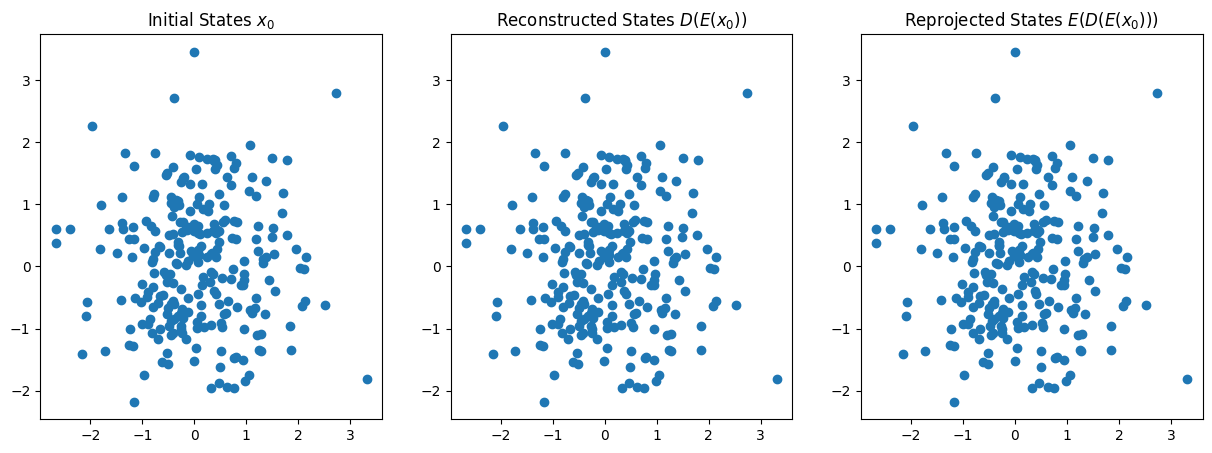

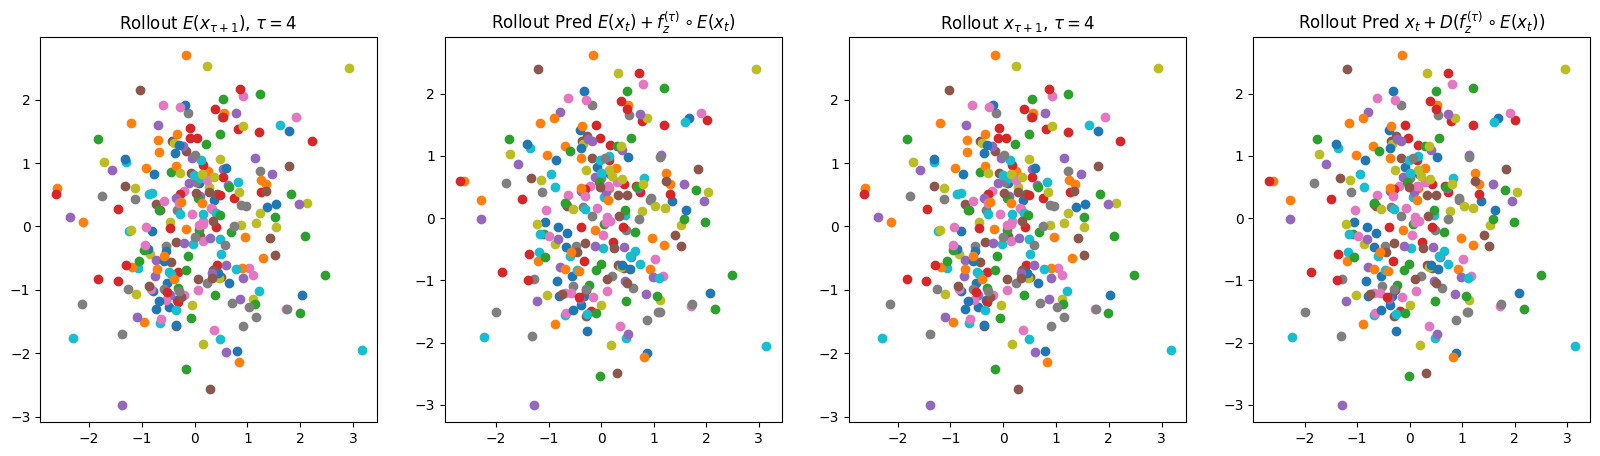

In [2]:
%load_ext autoreload
%autoreload 2
import sys, os.path as osp
sys.path.append(osp.dirname(osp.abspath("")))

import jax, jax.numpy as jnp, numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import random_split

from utils import get_repo_root, save_nnx_module, restore_nnx_module
from data_gen import *
from rom import *

cfg_train = CfgTrain()
cfg_loss = CfgLoss()
cfg_rom = CfgNNDoubinteROM()

dataset = DoubinteDataset(cfg=CfgDataLoad(), 
                        data_path=osp.join(get_repo_root(), "data/doubinte_data_5e4.npz"))
train_set, eval_set = random_split(dataset, [cfg_train.train_portion, 1-cfg_train.train_portion])
train_set.collate_fn = DoubinteDataset.collate_fn
eval_set.collate_fn = DoubinteDataset.collate_fn

# rom = NNDoubinteROM(cfg_rom)


rom = restore_nnx_module(lambda: NNDoubinteROM(cfg_rom, rngs=nnx.Rngs(0)),
                         f"{get_repo_root()}/logs/rom_5e4")

evaluate(rom, eval_set, cfg_train, cfg_loss)